In [184]:
import argparse
import datetime
import os
import re
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

import numpy as np

from src.cags_dataset import CAGS
import matplotlib.pyplot as plt
import tensorflow as tf


## Configure

In [185]:
parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", default=64, type=int, help="Batch size.")
parser.add_argument("--debug", default=False, action="store_true", help="If given, run functions eagerly.")
parser.add_argument("--epochs", default=10, type=int, help="Number of epochs.")
parser.add_argument("--seed", default=42, type=int, help="Random seed.")
parser.add_argument("--threads", default=1, type=int, help="Maximum number of threads to use.")

_StoreAction(option_strings=['--threads'], dest='threads', nargs=None, const=None, default=1, type=<class 'int'>, choices=None, required=False, help='Maximum number of threads to use.', metavar=None)

In [186]:
args = parser.parse_args([] if "__file__" not in globals() else None)

In [187]:
    # Set the random seed and the number of threads.
    tf.keras.utils.set_random_seed(args.seed)
    tf.config.threading.set_inter_op_parallelism_threads(args.threads)
    tf.config.threading.set_intra_op_parallelism_threads(args.threads)

    if args.debug:
        tf.config.run_functions_eagerly(True)
        # tf.data.experimental.enable_debug_mode()
    # Create logdir name
    args.logdir = os.path.join("logs", "{}-{}-{}".format(
        os.path.basename(globals().get("__file__", "notebook")),
        datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S"),
        ",".join(("{}={}".format(re.sub("(.)[^_]*_?", r"\1", k), v) for k, v in sorted(vars(args).items())))
    ))


## Load data

In [188]:
cags = CAGS()

## Visualize dataset

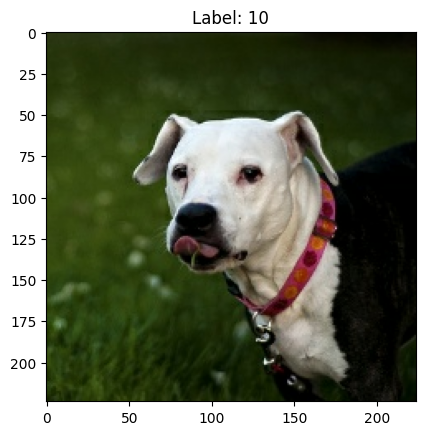

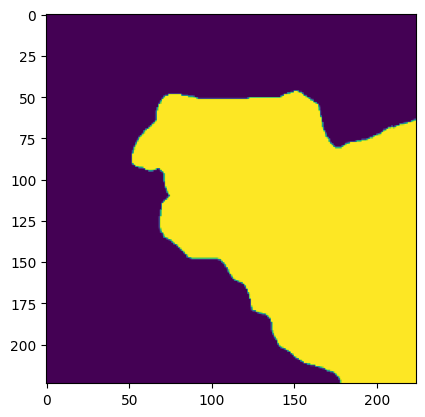

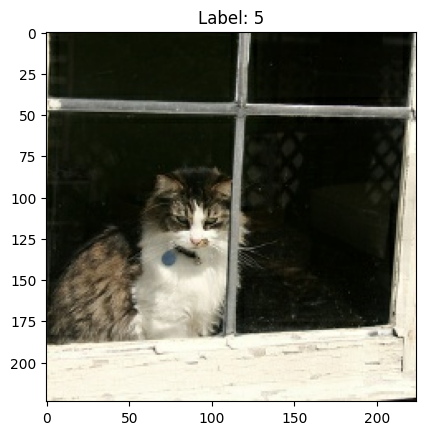

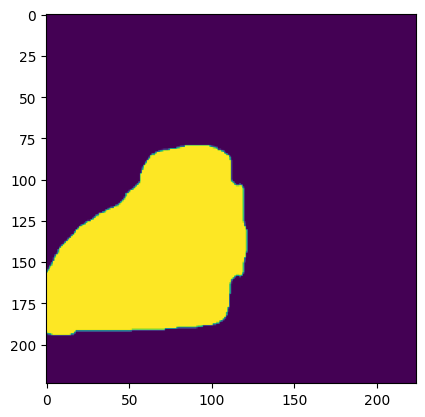

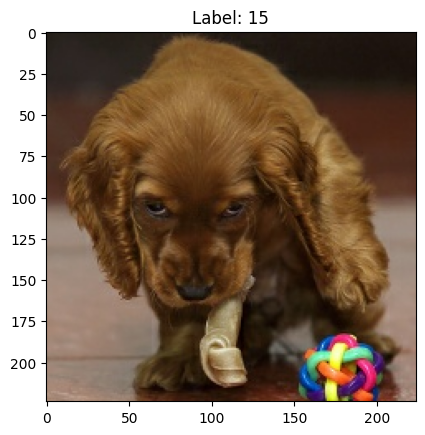

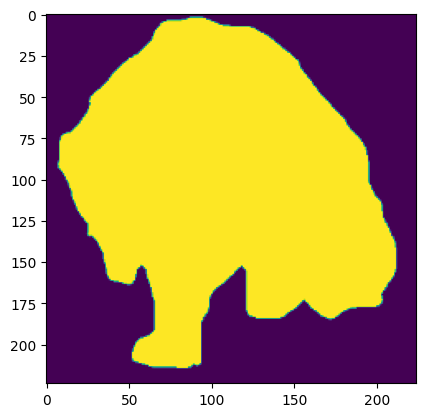

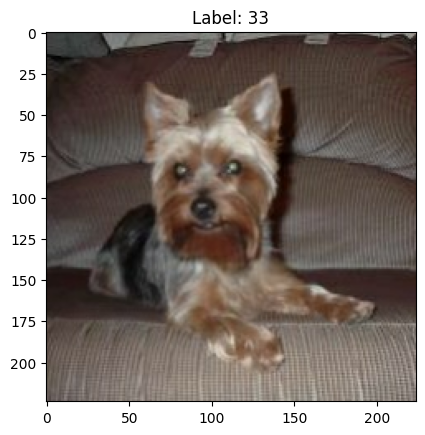

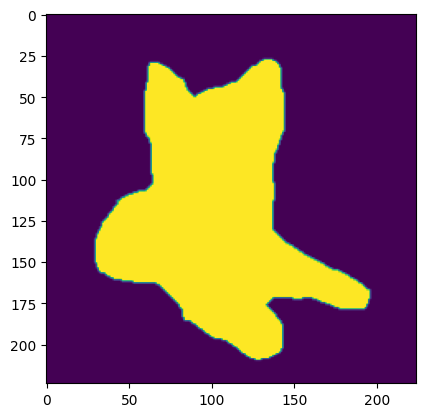

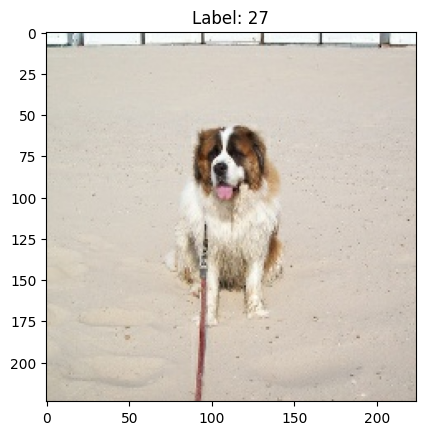

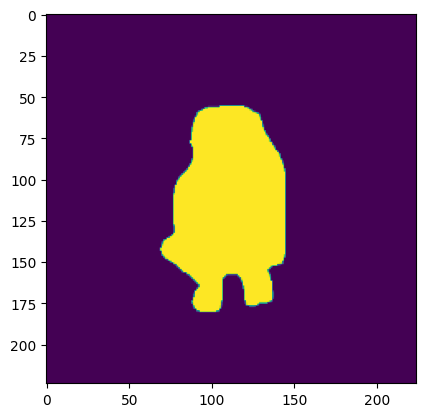

In [189]:
# Define the path to the TFRecord file
tfrecord_path = 'cags.dev.tfrecord'

# Create a TFRecordDataset
dataset = tf.data.TFRecordDataset(tfrecord_path)

# Parse the dataset using the cags.parse function
dataset = dataset.map(cags.parse)

# Define the number of images to plot
num_images_to_plot = 5

# Create an iterator and get the first `num_images_to_plot` images
example = dataset.take(num_images_to_plot)
for i in iter(example):
    # Display the image
    plt.figure()
    plt.imshow(i['image'].numpy())
    plt.title(f"Label: {i['label'].numpy()}")
    plt.show()
    plt.figure()
    plt.imshow(i['mask'].numpy())
    plt.show()


## data augmentation

In [275]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.9),
])

In [276]:
def augment_data(example):
    mask = tf.image.grayscale_to_rgb(example['mask'])
    mask = tf.cast(mask, 'uint8')

    images_mask = tf.concat([example['image'], mask], -1)  
    augmented_data = data_augmentation(images_mask)

    example['image'] = images_mask[:,:,0:3]
    example['mask'] = tf.image.rgb_to_grayscale(images_mask[:,:,3:6])
    #augmented_data[1] = tf.image.rgb_to_grayscale(augmented_data[1])
    return example

In [277]:
    # mask = tf.image.grayscale_to_rgb(i['mask'])


In [278]:
#     augmented_data = data_augmentation([i['image'],mask])
# augmented_data[0]

In [279]:
dataset = dataset.map(augment_data)


In [280]:
dataset

<_MapDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None)}>

<Figure size 1000x1000 with 0 Axes>

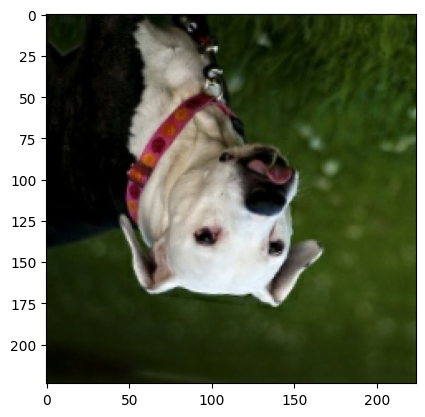

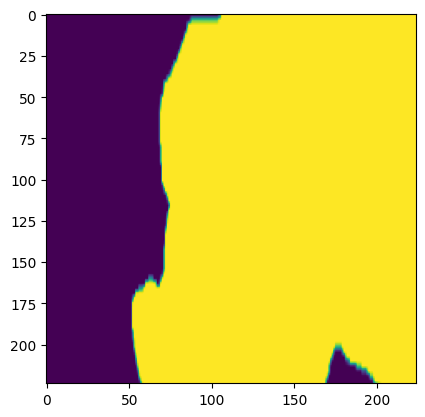

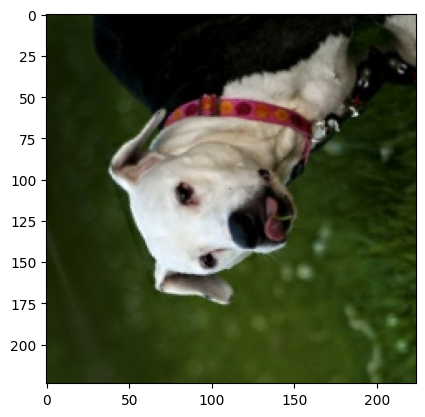

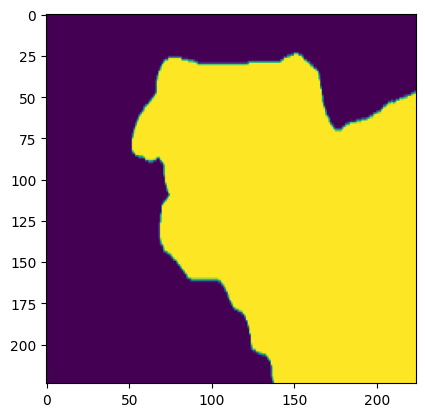

<Figure size 1000x1000 with 0 Axes>

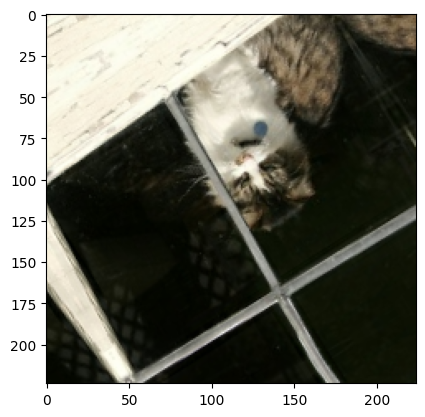

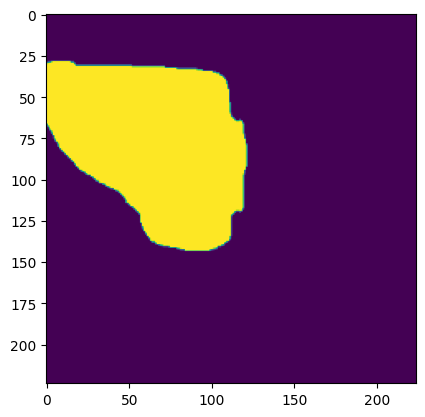

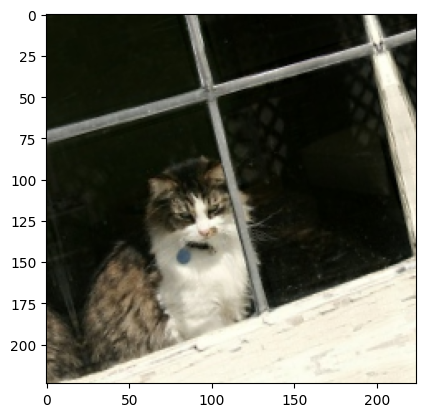

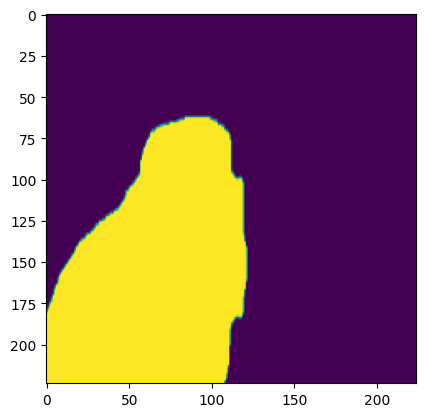

<Figure size 1000x1000 with 0 Axes>

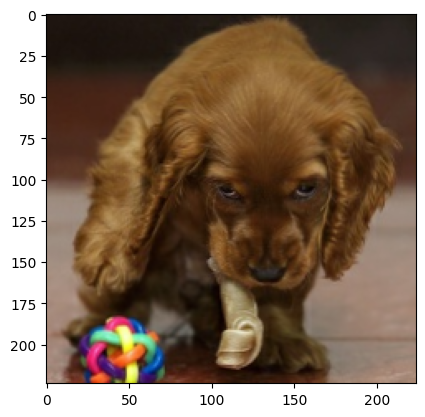

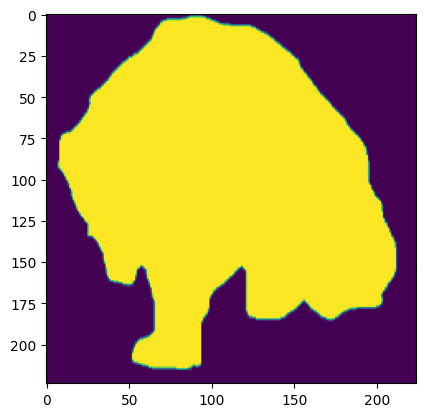

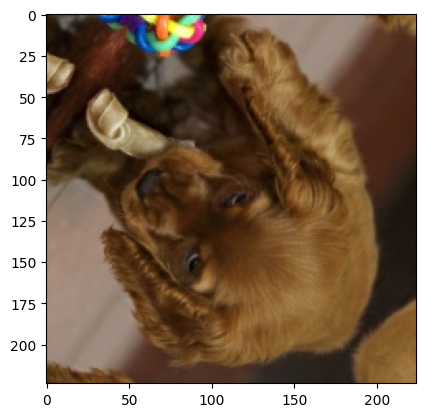

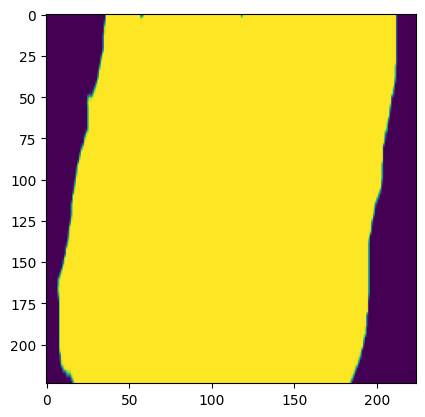

In [291]:
example = dataset.take(3)
for image in iter(example):
  plt.figure(figsize=(10, 10))
  first_image = image['image']
  first_mask = image['mask']
  for i in range(2):
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    augmented_mask = data_augmentation(tf.expand_dims(first_mask, 0))
    # Display the image
    plt.figure()
    plt.imshow(augmented_image[0] / 255)
    plt.show()
    plt.figure()
    plt.imshow(augmented_mask[0] / 255)
    plt.show()



In [289]:
tf.expand_dims(images_mask, 0)

<tf.Tensor: shape=(1, 224, 224, 6), dtype=uint8, numpy=
array([[[[ 37,  32,  26,   0,   0,   0],
         [ 37,  32,  26,   0,   0,   0],
         [ 37,  32,  26,   0,   0,   0],
         ...,
         [ 32,  23,  18,   0,   0,   0],
         [ 32,  23,  18,   0,   0,   0],
         [ 32,  23,  18,   0,   0,   0]],

        [[ 36,  31,  25,   0,   0,   0],
         [ 36,  31,  25,   0,   0,   0],
         [ 36,  31,  25,   0,   0,   0],
         ...,
         [ 31,  22,  17,   0,   0,   0],
         [ 31,  22,  17,   0,   0,   0],
         [ 31,  22,  17,   0,   0,   0]],

        [[ 37,  32,  26,   0,   0,   0],
         [ 36,  31,  25,   0,   0,   0],
         [ 37,  32,  26,   0,   0,   0],
         ...,
         [ 31,  22,  17,   0,   0,   0],
         [ 30,  21,  16,   0,   0,   0],
         [ 30,  21,  16,   0,   0,   0]],

        ...,

        [[166, 137, 119,   0,   0,   0],
         [169, 140, 122,   0,   0,   0],
         [170, 141, 123,   0,   0,   0],
         ...,
       

In [176]:
augmented_mask

<tf.Tensor: shape=(1, 224, 224), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

## Preprocess layer

In [13]:
# convert pixels from [0, 255] to the model specific scale. [-1,1] for efficientnet
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

<function keras.src.applications.efficientnet_v2.preprocess_input(x, data_format=None)>

## Load pretrained model

In [12]:
IMG_SIZE = (224, 224)

In [13]:
IMG_SHAPE = IMG_SIZE + (3,)
IMG_SHAPE

(224, 224, 3)

In [ ]:
    backbone = tf.keras.applications.EfficientNetV2L(include_top=False, input_shape=IMG_SHAPE)


In [56]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define a function to load and preprocess image-mask pairs
def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    mask = tf.image.decode_png(example['mask'], channels=1)
    
    # Perform any additional preprocessing as needed
    return image, mask

# Define a function to apply data augmentation to the image and its mask
def augment_data(image, mask):
    # Apply data augmentation to both image and mask
    augmented_data = data_augmentation([image, mask])
    augmented_image, augmented_mask = augmented_data[0], augmented_data[1]

    return augmented_image, augmented_mask

# Define the path to your TFRecord file
tfrecord_path = 'cags.dev.tfrecord'

# Create a TFRecordDataset and apply data augmentation to images and masks
dataset = tf.data.TFRecordDataset(tfrecord_path)
dataset = dataset.map(parse_tfrecord_fn)
dataset = dataset.map(augment_data)

# Create a function to visualize the images and masks
def visualize_images_and_masks(image, mask):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image.numpy())
    
    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask.numpy()[:, :, 0], cmap='gray')
    plt.show()

# Visualize the augmented image-mask pairs
for image, mask in dataset.take(3):
    visualize_images_and_masks(image, mask)

ValueError: in user code:

    File "/tmp/ipykernel_5445/1469248653.py", line 21, in augment_data  *
        augmented_data = data_augmentation([image, mask])
    File "/usr/local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'random_flip_2' (type RandomFlip).
    
    Dimension 2 in both shapes must be equal, but are 3 and 1. Shapes are [?,?,3] and [?,?,1].
    	From merging shape 0 with other shapes. for '{{node sequential_2/random_flip_2/packed}} = Pack[N=2, T=DT_FLOAT, axis=0](sequential_2/random_flip_2/Cast, sequential_2/random_flip_2/Cast_1)' with input shapes: [?,?,3], [?,?,1].
    
    Call arguments received by layer 'random_flip_2' (type RandomFlip):
      • inputs=['tf.Tensor(shape=(None, None, 3), dtype=uint8)', 'tf.Tensor(shape=(None, None, 1), dtype=uint8)']
      • training=True
